# SNA Project - Network Comparison Between In-Person Meetings and Phone Calls in Criminal Associations

### Library imports and network loading

In [32]:
import networkx as nx   # Key library for network analysis
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Load datasets
meetings_file = r'Dataset\Cleaned\Montagna_Meetings_Clean.csv'
df_meetings = pd.read_csv(meetings_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])
calls_file = r'Dataset\Cleaned\Montagna_Phone_Calls_Clean.csv'
df_calls = pd.read_csv(calls_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])

In [34]:
# Load roles
roles_file = r'Dataset\Cleaned\Montagna_Roles_Clean.csv'
df_roles = pd.read_csv(roles_file, names=['Node', 'Role', 'Relationship', 'Request'], header=None)
df_roles['Node'] = df_roles['Node'].astype(int) # Ensure Node column is treated as int

role_info = df_roles.set_index('Node').to_dict('index') # Convert to dictionary keyed by node ID

In [36]:
# Load networks from cleaned DataFrames
G_meetings = nx.Graph()
G_meetings.add_weighted_edges_from(df_meetings.values)
G_calls = nx.Graph()
G_calls.add_weighted_edges_from(df_calls.values)

# Add node roles to graphs
for node in G_meetings.nodes():
    if node in role_info:
        nx.set_node_attributes(G_meetings, {node: role_info[node]})
for node in G_calls.nodes():
    if node in role_info:
        nx.set_node_attributes(G_calls, {node: role_info[node]})

In [37]:
# Print summary of the graphs
print(f"Meetings: {G_meetings.number_of_nodes()} nodes, {G_meetings.number_of_edges()} edges")
print(f"Calls: {G_calls.number_of_nodes()} nodes, {G_calls.number_of_edges()} edges")
print(f"Nodes in common: {len(set(G_meetings.nodes()) & set(G_calls.nodes()))}")

print(G_meetings.nodes[2])  # Output: {'Role': 'boss family ...', 'Relationship': '', 'Request': ''}


Meetings: 95 nodes, 248 edges
Calls: 94 nodes, 120 edges
Nodes in common: 46
{'Role': "boss family ''Barcellona Pozzo di Gotto''", 'Relationship': nan, 'Request': nan}


In [ ]:
# DEBUG - Identify self-loops
def find_self_loops(G, name="Graph"):
    loops = list(nx.selfloop_edges(G))
    print(f"{name} - Number of self-loops: {len(loops)}")
    if loops:
        print("Self-loops found at nodes:", [u for u, _ in loops])

find_self_loops(G_meetings, name="Meetings")
find_self_loops(G_calls, name="Phone Calls")

# Meetings - Number of self-loops: 1. Self-loops found at nodes: ['N47']

Meetings - Number of self-loops: 0
Phone Calls - Number of self-loops: 0


In [ ]:
# DEBUG - Count and print duplicate edges
duplicates = df_meetings.duplicated(subset=['Source', 'Target'], keep=False)
print(f"Duplicate edge rows in meetings: {duplicates.sum()}")
if duplicates.any():
    print(df_meetings[duplicates].sort_values(by=['Source', 'Target']))

duplicates_calls = df_calls.duplicated(subset=['Source', 'Target'], keep=False)
print(f"Duplicate edge rows in calls: {duplicates_calls.sum()}")
if duplicates_calls.any():
    print(df_calls[duplicates_calls].sort_values(by=['Source', 'Target']))
    
# With directionality:
# Duplicate edge rows in meetings: 6
#      Source  Target  Weight
# 77       22      18       2
# 142      22      18       1
# 104      43      47       1
# 161      43      47       3
# 175      47      27       2
# 180      47      27       1
#      Source  Target  Weight
# 36       43      47       1
# 37       43      47       1
# 66       66      61       3
# 119      66      61       1

Duplicate edge rows in meetings: 0
Duplicate edge rows in calls: 0


### Plot the separated networks

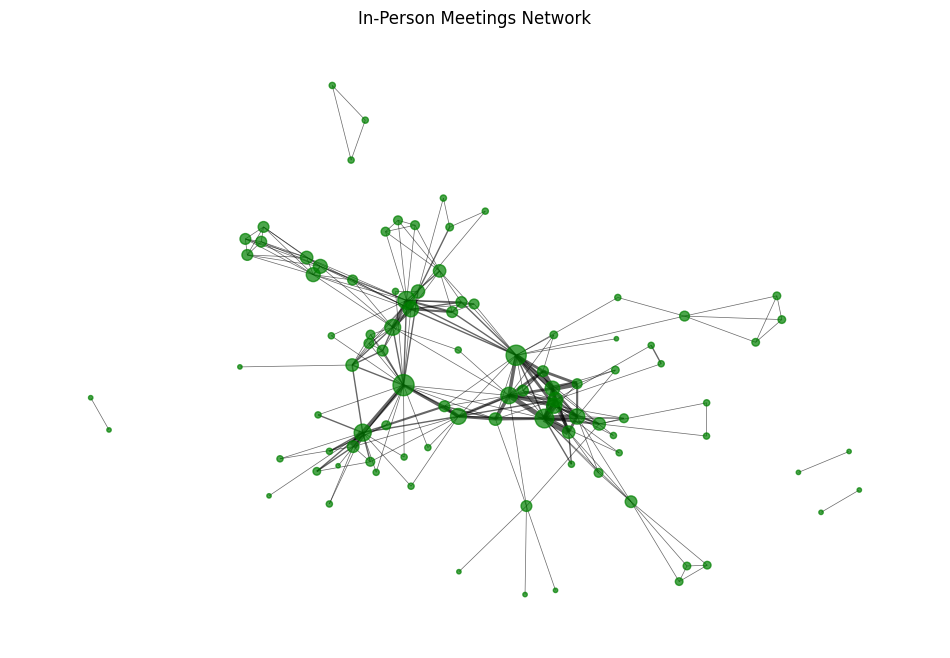

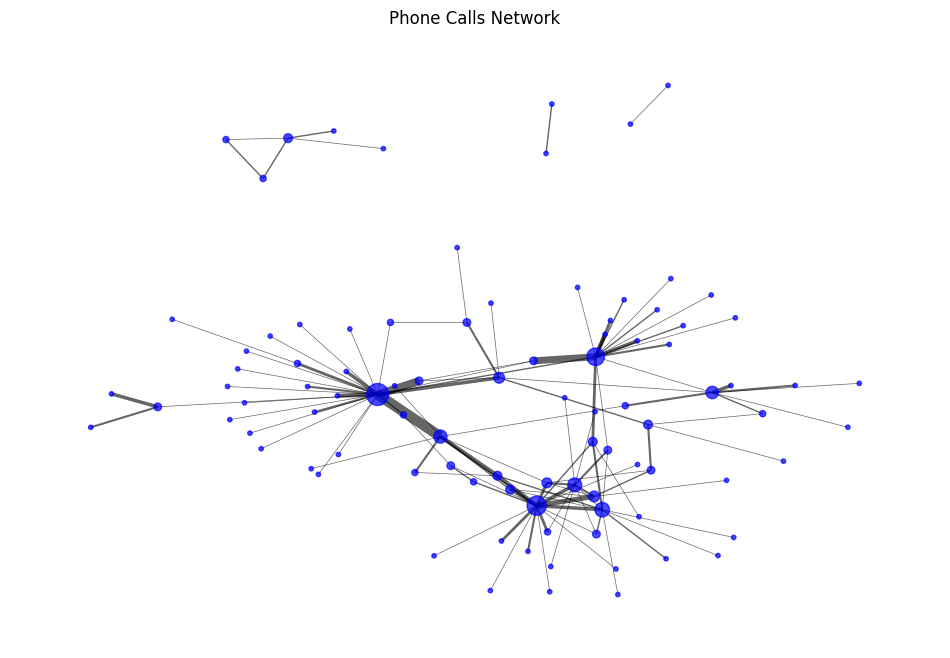

In [38]:
# Function to draw graphs. Scales node sizes by degree and edge widths by weight
def draw_graph(G, title, node_color='lightgray', edge_color='black'):
    plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * 10 for n in G.nodes()]  # Node size scaled by degree (scale factor = 10, can be adjusted)
    
    edge_weights = [G[u][v].get('weight', 1) * 0.5 for u, v in G.edges()]   # Edge width scaled by weight (scale factor = 0.5, can be adjusted)

    pos = nx.spring_layout(G, k=0.25, seed=42)  # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_color, alpha=0.6)
    #nx.draw_networkx_labels(G, pos, font_size=8)
    # If node has a role (not empty or nan), display it in the label
    labels = {
        n: f"{n}\n{data['Role']}"
        for n, data in G.nodes(data=True)
        if 'Role' in data and pd.notna(data['Role']) and str(data['Role']).strip() != ''
    }
    #nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')
    
    plt.title(title)
    plt.axis('off')
    plt.show()

draw_graph(G_meetings, "In-Person Meetings Network", node_color='green')
draw_graph(G_calls, "Phone Calls Network", node_color='blue')

### Aggregated Graph

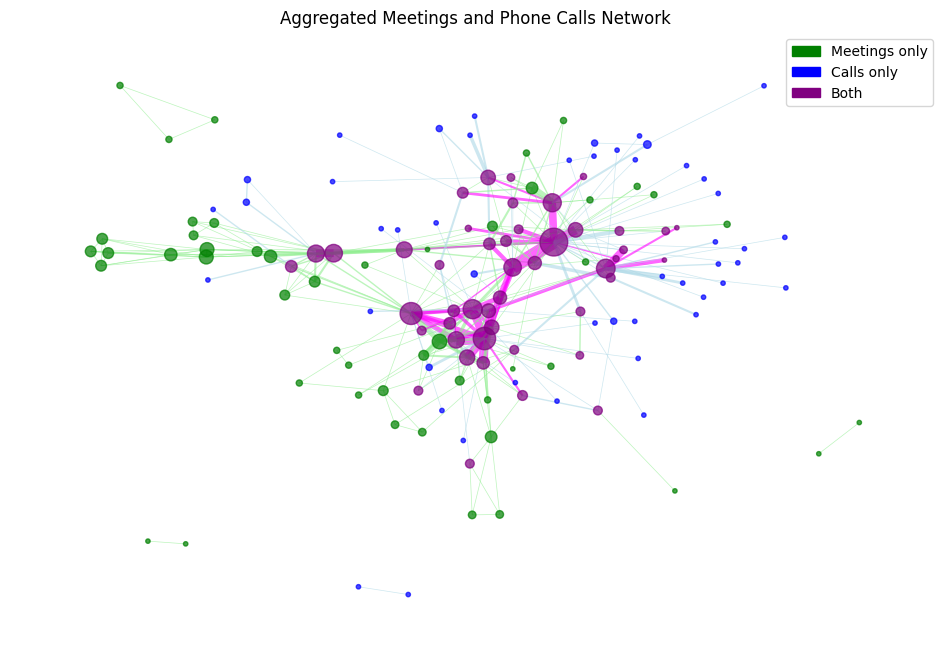

In [39]:
# Combine the two graphs in an "aggregated" graph
G_aggregated = nx.Graph()
# G_aggregated.add_edges_from(G_meetings.edges(data=True))  # data=True carries edge attributes (weights)
# G_aggregated.add_edges_from(G_calls.edges(data=True))     # Adds edges that are not already in the graph. Nodes in common are merged.

# Add meetings edges
for u, v, data in G_meetings.edges(data=True):
    w = data.get('weight', 1)
    if G_aggregated.has_edge(u, v):
        # If edge already exists, add the weight
        G_aggregated[u][v]['weight'] += w
        G_aggregated[u][v]['methods'].add('meetings')
    else:
        G_aggregated.add_edge(u, v, weight=w, methods={'meetings'})
# Add calls edges similarly
for u, v, data in G_calls.edges(data=True):
    w = data.get('weight', 1)
    if G_aggregated.has_edge(u, v):
        G_aggregated[u][v]['weight'] += w
        G_aggregated[u][v]['methods'].add('calls')
    else:
        G_aggregated.add_edge(u, v, weight=w, methods={'calls'})

# Add node roles to the aggregated graph
for node in G_aggregated.nodes():
    if node in role_info:
        nx.set_node_attributes(G_aggregated, {node: role_info[node]})

# Classify edges
edge_colors = []
for u, v in G_aggregated.edges():
    methods = G_aggregated[u][v]['methods']
    if methods == {'meetings'}:
        edge_colors.append('lightgreen')  # Meetings only
    elif methods == {'calls'}:
        edge_colors.append('lightblue')   # Calls only
    else:
        edge_colors.append('magenta') # Both

# Classify nodes
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())

node_colors = {}
for node in G_aggregated.nodes():
    in_meetings = node in nodes_meetings
    in_calls = node in nodes_calls
    if in_meetings and in_calls:
        node_colors[node] = 'purple'  # both
    elif in_meetings:
        node_colors[node] = 'green'   # only meetings
    elif in_calls:
        node_colors[node] = 'blue'    # only calls
colors_list = [node_colors[n] for n in G_aggregated.nodes()]  

# Node sizes (scaled by degree)
degrees = dict(G_aggregated.degree())
node_sizes = [degrees[n] * 10 for n in G_aggregated.nodes()]
edge_weights = [G_aggregated[u][v]['weight'] * 0.5 for u, v in G_aggregated.edges()]    # Edge thickness (scaled by weight, factor = 0.5)

pos = nx.spring_layout(G_aggregated, k=0.25, seed=42) # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
# Draw aggregated graph
nx.draw_networkx_nodes(G_aggregated, pos, node_color=colors_list, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G_aggregated, pos, width=edge_weights, edge_color=edge_colors, alpha=0.6)
#nx.draw_networkx_labels(G_aggregated, pos, font_size=8)

# Add legend
import matplotlib.patches as mpatches
legend = [mpatches.Patch(color='green', label='Meetings only'),
          mpatches.Patch(color='blue', label='Calls only'),
          mpatches.Patch(color='purple', label='Both')]
plt.legend(handles=legend)
plt.axis('off')
plt.title("Aggregated Meetings and Phone Calls Network")
plt.show()

### Multilayer graph

In [40]:
# Create empty multilayer graph
G_multi = nx.Graph()

# Layer 0: Meetings
for u, v, data in G_meetings.edges(data=True):
    G_multi.add_edge((u, 0), (v, 0), weight=data.get('weight', 1), layer='meetings')
# Layer 1: Calls
for u, v, data in G_calls.edges(data=True):
    G_multi.add_edge((u, 1), (v, 1), weight=data.get('weight', 1), layer='calls')
# Add interlayer edges: (same person across layers)
common_nodes = set(G_meetings.nodes()) & set(G_calls.nodes())
for node in common_nodes:
    G_multi.add_edge((node, 0), (node, 1), weight=1, layer='interlayer')

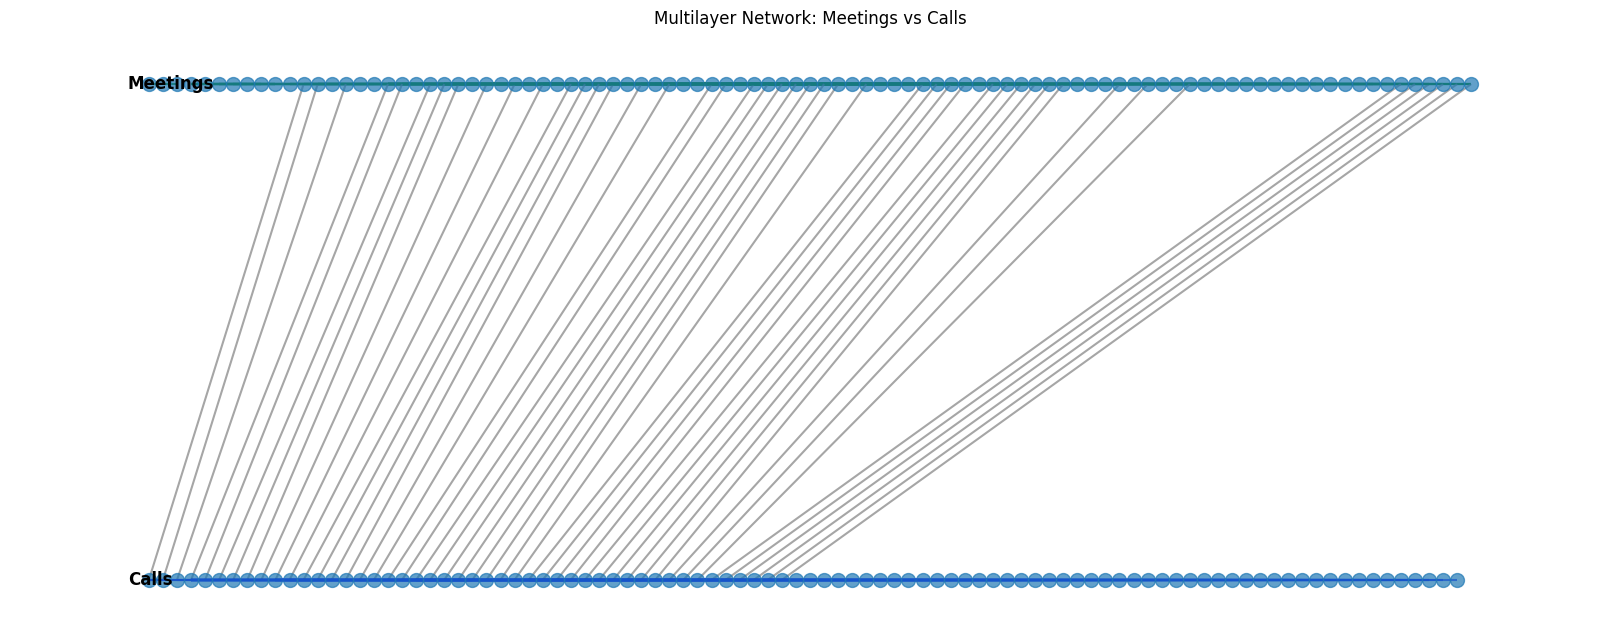

In [41]:
#Plot the multilayer graph
def plot_multilayer_graph(G_multi, layer_names={0: 'Meetings', 1: 'Calls'}):
    pos = {}
    layer_offset = 10  # vertical separation between layers
    x_spacing = 2

    # Separate nodes by layer
    nodes_by_layer = {0: [], 1: []}
    for node, layer in G_multi.nodes():
        nodes_by_layer[layer].append(node)

    # Assign positions
    for layer in [0, 1]:
        layer_nodes = sorted(nodes_by_layer[layer])
        for i, node in enumerate(layer_nodes):
            pos[(node, layer)] = (i * x_spacing, -layer * layer_offset)

    # Color edges by type
    edge_colors = []
    for u, v, data in G_multi.edges(data=True):
        if data.get('layer') == 'meetings':
            edge_colors.append('green')
        elif data.get('layer') == 'calls':
            edge_colors.append('blue')
        elif data.get('layer') == 'interlayer':
            edge_colors.append('gray')
        else:
            edge_colors.append('black')

    # Draw
    plt.figure(figsize=(16, 6))
    nx.draw(
        G_multi,
        pos,
        with_labels=False,
        node_size=100,
        edge_color=edge_colors,
        alpha=0.7,
        width=1.5
    )

    # Add layer labels
    for layer in [0, 1]:
        plt.text(
            -3, -layer * layer_offset,
            layer_names[layer],
            fontsize=12,
            fontweight='bold',
            verticalalignment='center'
        )

    plt.title("Multilayer Network: Meetings vs Calls")
    plt.axis('off')
    plt.show()

plot_multilayer_graph(G_multi, layer_names={0: 'Meetings', 1: 'Calls'})

### Graph analysis

In [42]:
# Find the nodes in common between the two graphs
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())
common_nodes = nodes_meetings & nodes_calls # Intersection

print(f"Nodes in common between Meetings and Phone Calls networks: {len(common_nodes)}")
print("Common nodes:", sorted(common_nodes))

Nodes in common between Meetings and Phone Calls networks: 46
Common nodes: [11, 12, 14, 18, 19, 21, 22, 23, 25, 27, 29, 31, 32, 33, 34, 36, 40, 43, 45, 47, 48, 49, 50, 51, 52, 54, 56, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 75, 77, 80, 95, 96, 97, 98, 99, 100]


In [43]:
# Function to print graph statistics. Statistics include:
# - Number of nodes, edges, and connected components
# - Max and average edge weight
# - Max and average node degree
# - Max shortest path length ("diameter") - Note: computes the diameter of the largest connected component
def print_graph_stats(G, name="Graph"):
    print(f"--- {name} ---")
    
    # Basic info (number of nodes, edges and components)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Connected components: {num_components}")
    
    # Edge weights
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    avg_weight = np.mean(edge_weights)
    print(f"Max edge weight: {max_weight}")
    print(f"Average edge weight: {avg_weight:.2f}")

    # Node degrees
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    avg_degree = np.mean(list(degrees.values()))
    print(f"Max node degree: {max_degree}")
    print(f"Average node degree: {avg_degree:.2f}")

    # Shortest path stats
    if nx.is_connected(G):  # Our graphs are disconnected, so this piece is always skipped
        diameter = nx.diameter(G)
    else:                   # Work on the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        diameter = nx.diameter(G_sub)
    print(f"Max shortest path length (diameter): {diameter}")
    
    print()  # Blank line for readability

In [44]:
print_graph_stats(G_meetings, name="Meetings Network")
print_graph_stats(G_calls, name="Phone Calls Network")

--- Meetings Network ---
Nodes: 95
Edges: 248
Connected components: 5
Max edge weight: 11
Average edge weight: 1.83
Max node degree: 23
Average node degree: 5.22
Max shortest path length (diameter): 6

--- Phone Calls Network ---
Nodes: 94
Edges: 120
Connected components: 4
Max edge weight: 15
Average edge weight: 2.30
Max node degree: 25
Average node degree: 2.55
Max shortest path length (diameter): 7



In [ ]:
print_graph_stats(G_aggregated, name="Aggregated Network")  # Note: there are 47 nodes *in common* between the two networks

--- Combined Network ---
Nodes: 143
Edges: 326
Connected components: 5
Max edge weight: 19
Average edge weight: 2.24
Max node degree: 40
Average node degree: 4.56
Max shortest path length (diameter): 6



In [14]:
# Function to print top X heaviest edges
def print_top_weight_edges(G, top_x=10):
    # Get all edges with weights
    edges_with_weights = [(u, v, d['weight']) for u, v, d in G.edges(data=True) if 'weight' in d]
    
    # Sort by weight descending
    top_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)[:top_x]
    
    print(f"Top {top_x} heaviest edges (u, v, weight):")
    for u, v, w in top_edges:
        print(f"{u} -- {v} (weight: {w})")

# Function to print top X nodes by degree
def print_top_degree_nodes(G, top_x=10):
    # Compute degrees
    degrees = G.degree()
    
    # Sort by degree descending
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:top_x]
    
    print(f"Top {top_x} nodes by degree (node, degree):")
    for node, deg in top_nodes:
        print(f"{node} (degree: {deg})")

In [ ]:
print("Meetings Network:")
print_top_degree_nodes(G_meetings, top_x=10)
print_top_weight_edges(G_meetings, top_x=10)

print("Phone Calls Network:")
print_top_degree_nodes(G_calls, top_x=10)
print_top_weight_edges(G_calls, top_x=10)

print("Aggregated Network:")
print_top_degree_nodes(G_aggregated, top_x=10)
print_top_weight_edges(G_aggregated, top_x=10)

Meetings Network:
Top 10 nodes by degree (node, degree):
18 (degree: 23)
68 (degree: 21)
47 (degree: 18)
12 (degree: 16)
22 (degree: 15)
27 (degree: 14)
25 (degree: 13)
29 (degree: 13)
11 (degree: 12)
45 (degree: 12)
Top 10 heaviest edges (u, v, weight):
22 -- 76 (weight: 11)
11 -- 12 (weight: 10)
47 -- 50 (weight: 10)
47 -- 45 (weight: 9)
47 -- 48 (weight: 8)
89 -- 93 (weight: 8)
68 -- 89 (weight: 7)
27 -- 47 (weight: 7)
70 -- 89 (weight: 7)
18 -- 22 (weight: 6)
Phone Calls Network:
Top 10 nodes by degree (node, degree):
18 (degree: 25)
47 (degree: 19)
61 (degree: 16)
27 (degree: 11)
68 (degree: 10)
29 (degree: 9)
75 (degree: 8)
22 (degree: 6)
45 (degree: 6)
54 (degree: 5)
Top 10 heaviest edges (u, v, weight):
18 -- 29 (weight: 15)
18 -- 19 (weight: 11)
61 -- 66 (weight: 10)
47 -- 45 (weight: 7)
18 -- 33 (weight: 6)
29 -- 43 (weight: 6)
61 -- 128 (weight: 6)
43 -- 47 (weight: 6)
18 -- 22 (weight: 5)
18 -- 100 (weight: 5)
Combined Network:
Top 10 nodes by degree (node, degree):
18 (deg

### Further analysis

In [ ]:
def degree_centrality(G):   # degree divided by (n-1), where n is the number of nodes
    """Unweighted degree centrality."""
    return nx.degree_centrality(G)

def weighted_degree_centrality(G):  # same as degree centrality, but considers edge weights
    """Weighted degree centrality (node strength)."""
    n = len(G)
    return {node: sum(d['weight'] for _, _, d in G.edges(node, data=True)) / (n-1) for node in G.nodes()}

def betweenness_centrality(G, weight=None):     # Importance is defined as the number of shortest paths that pass through a node
    """Betweenness centrality, optionally weighted."""
    return nx.betweenness_centrality(G, weight=weight)

def katz_centrality(G, alpha=0.1, beta=1.0):    # Importance is defined based on the importance of neighboring nodes
    """Katz centrality using numpy method for stability."""
    try:
        return nx.katz_centrality_numpy(G, alpha=alpha, beta=beta, weight='weight')
    except nx.NetworkXException as e:
        print("Katz centrality error:", e)
        return {}

def collective_influence(G, radius=2):          # Importance is defined based on the influence of neighboring nodes within a certain radius
    """Collective Influence centrality as defined in Morone & Makse (2015)."""
    CI = {}
    for node in G.nodes():
        ki = G.degree(node)
        if ki <= 1:
            CI[node] = 0
            continue
        ball = nx.ego_graph(G, node, radius=radius, center=False)
        boundary = set(ball.nodes())
        sigma = sum(G.degree(n) - 1 for n in boundary)
        CI[node] = (ki - 1) * sigma
    return CI

def pagerank(G, alpha=0.85, weight='weight'):   # Importance is defined based on the probability of random walks to cross that node
    """PageRank centrality, weighted by default."""
    return nx.pagerank(G, alpha=alpha, weight=weight)

In [ ]:
arr_deg_meetings = degree_centrality(G_meetings)
arr_wdeg_meetings = weighted_degree_centrality(G_meetings)
arr_btw_meetings = betweenness_centrality(G_meetings, weight='weight')
arr_katz_meetings = katz_centrality(G_meetings)
arr_ci_meetings = collective_influence(G_meetings, radius=2)
arr_pr_meetings = pagerank(G_meetings)

arr_deg_calls = degree_centrality(G_calls)
arr_wdeg_calls = weighted_degree_centrality(G_calls)
arr_btw_calls = betweenness_centrality(G_calls, weight='weight')
arr_katz_calls = katz_centrality(G_calls)
arr_ci_calls = collective_influence(G_calls, radius=2)
arr_pr_calls = pagerank(G_calls)

arr_deg_aggregated = degree_centrality(G_aggregated)
arr_wdeg_aggregated = weighted_degree_centrality(G_aggregated)
arr_btw_aggregated = betweenness_centrality(G_aggregated, weight='weight')
arr_katz_aggregated = katz_centrality(G_aggregated)
arr_ci_aggregated = collective_influence(G_aggregated, radius=2)
arr_pr_aggregated = pagerank(G_aggregated)

In [ ]:
# DEBUG - Print all measures
print("Degree Centrality (Meetings):", arr_deg_meetings)
print("Weighted Degree Centrality (Meetings):", arr_wdeg_meetings)
print("Betweenness Centrality (Meetings):", arr_btw_meetings)
print("Katz Centrality (Meetings):", arr_katz_meetings)
print("Collective Influence (Meetings):", arr_ci_meetings)
print("PageRank (Meetings):", arr_pr_meetings)
print("")
print("Degree Centrality (Calls):", arr_deg_calls)
print("Weighted Degree Centrality (Calls):", arr_wdeg_calls)
print("Betweenness Centrality (Calls):", arr_btw_calls)
print("Katz Centrality (Calls):", arr_katz_calls)
print("Collective Influence (Calls):", arr_ci_calls)
print("PageRank (Calls):", arr_pr_calls)
print("")
print("Degree Centrality (Aggregated):", arr_deg_aggregated)
print("Weighted Degree Centrality (Aggregated):", arr_wdeg_aggregated)
print("Betweenness Centrality (Aggregated):", arr_btw_aggregated)
print("Katz Centrality (Aggregated):", arr_katz_aggregated)
print("Collective Influence (Aggregated):", arr_ci_aggregated)
print("PageRank (Aggregated):", arr_pr_aggregated)

Degree Centrality (Meetings): {0: 0.02127659574468085, 1: 0.02127659574468085, 2: 0.02127659574468085, 3: 0.0851063829787234, 4: 0.06382978723404255, 5: 0.10638297872340426, 6: 0.10638297872340426, 7: 0.06382978723404255, 8: 0.06382978723404255, 9: 0.06382978723404255, 11: 0.1276595744680851, 12: 0.1702127659574468, 25: 0.13829787234042554, 28: 0.05319148936170213, 10: 0.05319148936170213, 13: 0.06382978723404255, 14: 0.06382978723404255, 68: 0.22340425531914893, 18: 0.24468085106382978, 85: 0.0851063829787234, 21: 0.02127659574468085, 84: 0.0425531914893617, 86: 0.0425531914893617, 87: 0.0425531914893617, 16: 0.010638297872340425, 17: 0.010638297872340425, 19: 0.09574468085106383, 20: 0.02127659574468085, 22: 0.1595744680851064, 23: 0.0851063829787234, 27: 0.14893617021276595, 29: 0.13829787234042554, 31: 0.02127659574468085, 34: 0.06382978723404255, 35: 0.05319148936170213, 43: 0.0851063829787234, 47: 0.19148936170212766, 59: 0.02127659574468085, 60: 0.02127659574468085, 63: 0.042553

In [19]:
# Print top X nodes based on a centrality measure (dicts of (node:value) sorted by value)
def print_top_centrality(arr, top_x=10):
    """Prints top X nodes by centrality measure."""
    sorted_nodes = sorted(arr.items(), key=lambda x: x[1], reverse=True)[:top_x]
    print(f"Top {top_x} nodes by centrality measure:")
    for node, value in sorted_nodes:
        print(f"{node}: {value:.4f}")

In [ ]:
print_top_centrality(arr_btw_aggregated, top_x=10)

Top 10 nodes by centrality measure:
18: 0.4485
68: 0.2245
47: 0.1986
61: 0.1525
43: 0.1373
11: 0.1275
27: 0.1122
75: 0.0895
76: 0.0625
29: 0.0595


In [ ]:
# Function to print table of top X nodes by degree centrality
# 4 columns: one for the nodes, 3 for the deg. centrality of the aggregated, the meetings and the calls graphs. Sorts nodes by degree centrality value of the aggregated graph.
def print_top_degree_table(arr_aggregated, arr_meetings, arr_calls, top_x=10, unnormalized=False):
    """Prints a table of top X nodes by degree centrality."""
    sorted_nodes = sorted(arr_aggregated.items(), key=lambda x: x[1], reverse=True)[:top_x]
    
    print(f"{'Node':<10} {'Aggregated':<10} {'Meetings':<10} {'Calls':<10}")
    print("-" * 40)
    for node, value in sorted_nodes:
        meetings_value = arr_meetings.get(node, 0)
        calls_value = arr_calls.get(node, 0)
        if unnormalized:    # multiply by (n-1) and round to avoid decimals
            value = round(value * (len(arr_aggregated) - 1))
            meetings_value = round(meetings_value * (len(arr_meetings) - 1))
            calls_value = round(calls_value * (len(arr_calls) - 1))
            print (f"{node:<10} {value:<10} {meetings_value:<10} {calls_value:<10}")
        else:
            print(f"{node:<10} {value:<10.4f} {meetings_value:<10.4f} {calls_value:<10.4f}")

In [ ]:
print_top_degree_table(arr_deg_aggregated, arr_deg_meetings, arr_deg_calls, top_x=10, unnormalized=True)
print("")
print_top_degree_table(arr_deg_aggregated, arr_deg_meetings, arr_deg_calls, top_x=10, unnormalized=False)

Node       Combined   Meetings   Calls     
----------------------------------------
18         40         23         25        
47         26         18         19        
68         25         21         10        
27         19         14         11        
61         18         6          16        
22         17         15         6         
12         16         16         1         
29         16         13         9         
11         15         12         4         
45         14         12         6         

Node       Combined   Meetings   Calls     
----------------------------------------
18         0.2817     0.2447     0.2688    
47         0.1831     0.1915     0.2043    
68         0.1761     0.2234     0.1075    
27         0.1338     0.1489     0.1183    
61         0.1268     0.0638     0.1720    
22         0.1197     0.1596     0.0645    
12         0.1127     0.1702     0.0108    
29         0.1127     0.1383     0.0968    
11         0.1056     0.1277     0.04